# Comparing ActiSwitch and Skip Connections (Vanishing Gradients)

This notebook explores the comparison between **ActiSwitch** and **skip connections** in a neural network architecture using the **Tanh** activation function. Tanh is prone to the **vanishing gradient problem**, where gradients become too small to effectively update deeper layers in the network.

Skip connections are typically used to address this issue by allowing gradients to flow more freely through the network. However, this experiment shows that the **ActiSwitch layer** can surpass skip connections after longer training. ActiSwitch enables the network to adjust dynamically between linear and non-linear behavior, improving gradient flow without depending solely on skip connections.

After training for **50 epochs**, ActiSwitch demonstrates better performance, overcoming the vanishing gradient issue more effectively than skip connections. Additionally, ActiSwitch achieves **conversion speed and accuracy comparable to Tanh**, matching the performance of networks using **ReLU** activation functions. This ability to maintain effective gradient flow across varying activation functions makes ActiSwitch a versatile choice for deep architectures.

That said, both architectures exhibit signs of **overfitting**, with ActiSwitch suffering from overfitting to a greater extent. 

Importantly, **ActiSwitch's performance can be significantly improved** by employing **regularization techniques** such as **L1/L2 regularization**, **dropout**, or **normalization** to reduce overfitting. These methods could enable ActiSwitch to reach even higher accuracy by ensuring that the network generalizes better, rather than memorizing the training data.

In conclusion, **ActiSwitch is a promising technique**, especially when combined with appropriate regularization methods. With its ability to **match the performance of ReLU** while handling vanishing gradient problems like Tanh, it presents an exciting avenue for future research. With further refinement, ActiSwitch has the potential to outperform traditional architectures like skip connections in terms of both speed and gradient flow, making it a powerful tool for designing deep networks.

---

This version emphasizes ActiSwitch's capacity to achieve both the speed and accuracy of different activation functions and its potential when combined with regularization.

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [24]:
# Define the ResNet block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.Tanh()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

# Define ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.Tanh()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])

In [25]:
class ActiSwitch(nn.Module):
    def __init__(self, activation_function):
        super(ActiSwitch, self).__init__()
        # Placeholder for ActiSwitch functionality
        self.acti = activation_function()
        self.linear_weight = nn.Parameter(torch.tensor(0.0))
        self.activation_weight = nn.Parameter(torch.tensor(1.0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_weight * x + self.activation_weight * self.acti(x)

# Custom architecture using ActiSwitch instead of regular activations
class CustomResNetNoSkipActiSwitch(nn.Module):
    def __init__(self):
        super(CustomResNetNoSkipActiSwitch, self).__init__()

        # Initial Conv Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = ActiSwitch(nn.Tanh)  # ActiSwitch after Conv layer
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Block 1 (2 layers without skip connections)
        self.conv2_1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.act2_1 = ActiSwitch(nn.Tanh)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.act2_2 = ActiSwitch(nn.Tanh)

        # ResNet Block 2 (with downsampling)
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.act3_1 = ActiSwitch(nn.Tanh)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3_2 = nn.BatchNorm2d(128)
        self.act3_2 = ActiSwitch(nn.Tanh)

        # ResNet Block 3 (with downsampling)
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.act4_1 = ActiSwitch(nn.Tanh)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4_2 = nn.BatchNorm2d(256)
        self.act4_2 = ActiSwitch(nn.Tanh)

        # ResNet Block 4 (with downsampling)
        self.conv5_1 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.act5_1 = ActiSwitch(nn.Tanh)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5_2 = nn.BatchNorm2d(512)
        self.act5_2 = ActiSwitch(nn.Tanh)

        # Final layers (Global Average Pooling and Linear layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 100)  # Output for CIFAR-100

    def forward(self, x):
        # Initial Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.maxpool(x)

        # ResNet Block 1
        x = self.conv2_1(x)
        x = self.bn2_1(x)
        x = self.act2_1(x)
        x = self.conv2_2(x)
        x = self.bn2_2(x)
        x = self.act2_2(x)

        # ResNet Block 2
        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = self.act3_1(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = self.act3_2(x)

        # ResNet Block 3
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.act4_1(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.act4_2(x)

        # ResNet Block 4
        x = self.conv5_1(x)
        x = self.bn5_1(x)
        x = self.act5_1(x)
        x = self.conv5_2(x)
        x = self.bn5_2(x)
        x = self.act5_2(x)

        # Final layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [26]:
# Data preparation for CIFAR-100
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Training the model and storing loss and accuracy
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return epoch_losses, epoch_accuracies

In [28]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f'Test Accuracy: {100*correct/total:.2f}%')

In [29]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Train and evaluate the model
losses_1, accuracies_1 = train_model(model, train_loader, criterion, optimizer, num_epochs=50)
evaluate_model(model, test_loader)

Epoch [1/50], Loss: 4.0060, Accuracy: 8.64%
Epoch [2/50], Loss: 3.5676, Accuracy: 14.64%
Epoch [3/50], Loss: 3.2795, Accuracy: 19.61%
Epoch [4/50], Loss: 3.0620, Accuracy: 23.38%
Epoch [5/50], Loss: 2.8964, Accuracy: 26.89%
Epoch [6/50], Loss: 2.7550, Accuracy: 29.85%
Epoch [7/50], Loss: 2.6360, Accuracy: 32.03%
Epoch [8/50], Loss: 2.5350, Accuracy: 34.18%
Epoch [9/50], Loss: 2.4503, Accuracy: 35.67%
Epoch [10/50], Loss: 2.3684, Accuracy: 37.48%
Epoch [11/50], Loss: 2.2899, Accuracy: 39.46%
Epoch [12/50], Loss: 2.2289, Accuracy: 40.64%
Epoch [13/50], Loss: 2.1591, Accuracy: 42.19%
Epoch [14/50], Loss: 2.0991, Accuracy: 43.58%
Epoch [15/50], Loss: 2.0483, Accuracy: 44.88%
Epoch [16/50], Loss: 1.9876, Accuracy: 45.92%
Epoch [17/50], Loss: 1.9265, Accuracy: 47.43%
Epoch [18/50], Loss: 1.8802, Accuracy: 48.32%
Epoch [19/50], Loss: 1.8230, Accuracy: 49.84%
Epoch [20/50], Loss: 1.7798, Accuracy: 50.67%
Epoch [21/50], Loss: 1.7289, Accuracy: 51.90%
Epoch [22/50], Loss: 1.6835, Accuracy: 52.95

In [31]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomResNetNoSkipActiSwitch().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Train and evaluate the model
losses_2, accuracies_2 = train_model(model, train_loader, criterion, optimizer, num_epochs=50)
evaluate_model(model, test_loader)

Epoch [1/50], Loss: 3.8732, Accuracy: 10.67%
Epoch [2/50], Loss: 3.3951, Accuracy: 18.07%
Epoch [3/50], Loss: 3.1149, Accuracy: 22.85%
Epoch [4/50], Loss: 2.9240, Accuracy: 26.40%
Epoch [5/50], Loss: 2.7715, Accuracy: 29.45%
Epoch [6/50], Loss: 2.6471, Accuracy: 32.13%
Epoch [7/50], Loss: 2.5334, Accuracy: 34.36%
Epoch [8/50], Loss: 2.4434, Accuracy: 36.38%
Epoch [9/50], Loss: 2.3560, Accuracy: 38.08%
Epoch [10/50], Loss: 2.2797, Accuracy: 40.03%
Epoch [11/50], Loss: 2.1927, Accuracy: 41.80%
Epoch [12/50], Loss: 2.1275, Accuracy: 43.18%
Epoch [13/50], Loss: 2.0538, Accuracy: 45.07%
Epoch [14/50], Loss: 1.9885, Accuracy: 46.37%
Epoch [15/50], Loss: 1.9077, Accuracy: 48.02%
Epoch [16/50], Loss: 1.8454, Accuracy: 49.56%
Epoch [17/50], Loss: 1.7616, Accuracy: 51.30%
Epoch [18/50], Loss: 1.7002, Accuracy: 53.00%
Epoch [19/50], Loss: 1.6156, Accuracy: 54.89%
Epoch [20/50], Loss: 1.5419, Accuracy: 56.79%
Epoch [21/50], Loss: 1.4693, Accuracy: 58.65%
Epoch [22/50], Loss: 1.3823, Accuracy: 60.6

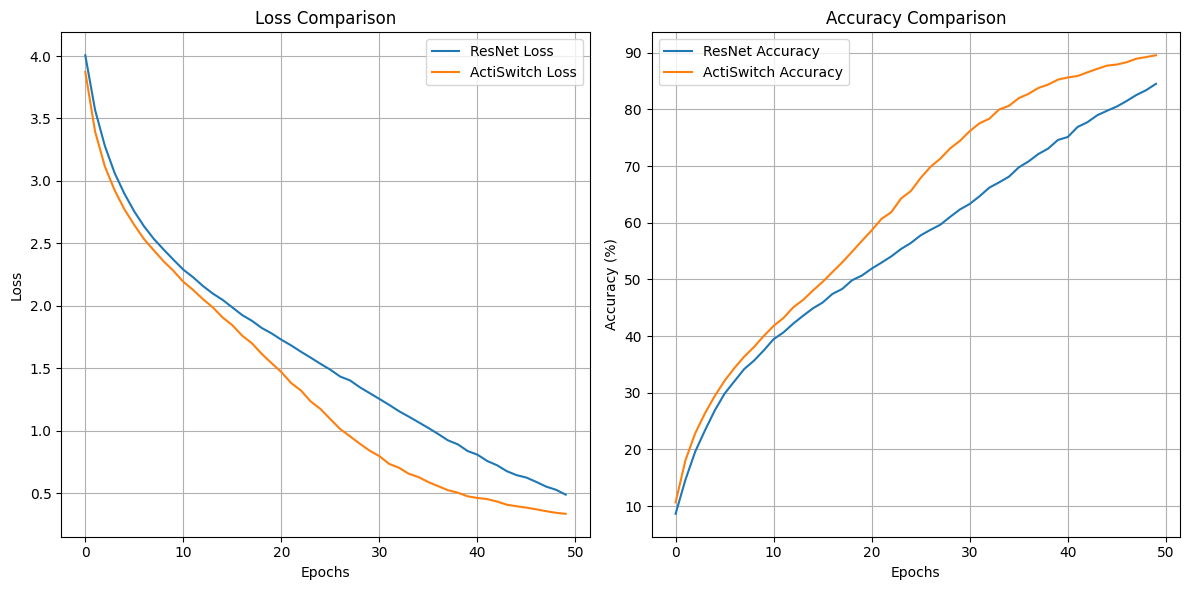

In [33]:
# Plotting function to compare two architectures
def plot_comparison(losses_1, accuracies_1, losses_2, accuracies_2, model_name_1="ResNet", model_name_2="ActiSwitch"):
    # Plot Losses
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(losses_1, label=f'{model_name_1} Loss')
    plt.plot(losses_2, label=f'{model_name_2} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.grid(True)
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(accuracies_1, label=f'{model_name_1} Accuracy')
    plt.plot(accuracies_2, label=f'{model_name_2} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Comparison')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison(losses_1, accuracies_1, losses_2, accuracies_2, model_name_1="ResNet", model_name_2="ActiSwitch")